In [ ]:
### Purpose: classify exons into constitutive/alternative - Figure S2C
### Input: annotation.gtf, csv files with exon coordinates (outputs from scripts 1 and 3) 
### Date: 04/30/2025

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


In [10]:
# Load GTF file or create a DataFrame with relevant columns
gtf = pd.read_csv('gencode.v44.basic.annotation.gtf', sep='\t', comment='#', header=None, names=[
        'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
# Filter exons
exons = gtf[gtf['feature'] == 'exon']

# Extract gene and transcript IDs from the 'attributes' column
exons['gene_id'] = exons['attribute'].str.extract(r'gene_id "([^"]+)"')
exons['transcript_id'] = exons['attribute'].str.extract(r'transcript_id "([^"]+)"')

# Group by gene and exon coordinates, and count transcript IDs
exon_transcript_counts = (
    exons.groupby(['gene_id', 'chrom', 'start', 'end'])
    .agg(transcript_count=('transcript_id', 'nunique'))
    .reset_index()
)

# Count total transcripts per gene
gene_transcript_counts = exons.groupby('gene_id')['transcript_id'].nunique().reset_index()
gene_transcript_counts.rename(columns={'transcript_id': 'total_transcripts'}, inplace=True)

# Merge exon counts with total transcript counts
exon_transcript_counts = exon_transcript_counts.merge(gene_transcript_counts, on='gene_id')

# Classify exons as constitutive or alternative
exon_transcript_counts['type'] = exon_transcript_counts.apply(
    lambda x: 'constitutive' if x['transcript_count'] == x['total_transcripts'] else 'alternative', axis=1
)


/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_76106/4184247224.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exons['gene_id'] = exons['attribute'].str.extract(r'gene_id "([^"]+)"')
/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_76106/4184247224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exons['transcript_id'] = exons['attribute'].str.extract(r'transcript_id "([^"]+)"')


In [11]:
# Save the results
exon_transcript_counts.to_csv("exon_classification.gencodev44.csv", index=False)

In [12]:
#### ---- Determine if exons are alternative or constitutive ----

In [16]:
other_reg = pd.read_csv('other_regulated_exons.csv')
blocks = pd.read_csv('block_exons_ddPSImax0.2_adjacent.moreSKIPPED.csv')
whip = pd.read_csv('whippet_CE_gene_name_exon_number_exon_length.csv')
incl = pd.read_csv('block_exons_ddPSImax0.2_adjacent.moreINCLUDED.csv')
sig_whippet = pd.read_csv('sig_whip_CE_prob0.9_dPSI0.1.csv')

In [17]:
# Split Coord in other_reg
other_reg[['chrom', 'start', 'end']] = other_reg['Coord'].str.extract(r'(chr\w+):(\d+)-(\d+)')
other_reg[['start', 'end']] = other_reg[['start', 'end']].astype(int)

# Split Coord in blocks
blocks[['chrom', 'start', 'end']] = blocks['Coord'].str.extract(r'(chr\w+):(\d+)-(\d+)')
blocks[['start', 'end']] = blocks[['start', 'end']].astype(int)

# Split Coord in whip
whip[['chrom', 'start', 'end']] = whip['Coord'].str.extract(r'(chr\w+):(\d+)-(\d+)')
whip[['start', 'end']] = whip[['start', 'end']].astype(int)

# Split Coord in sig_whippet
sig_whippet[['chrom', 'start', 'end']] = sig_whippet['Coord'].str.extract(r'(chr\w+):(\d+)-(\d+)')
sig_whippet[['start', 'end']] = sig_whippet[['start', 'end']].astype(int)

# Split Coord in incl
incl[['chrom', 'start', 'end']] = incl['Coord'].str.extract(r'(chr\w+):(\d+)-(\d+)')
incl[['start', 'end']] = incl[['start', 'end']].astype(int)

# Merge other_reg with exon_transcript_counts
other_reg_merged = other_reg.merge(
    exon_transcript_counts,
    left_on=['Gene', 'chrom', 'start', 'end'],
    right_on=['gene_id', 'chrom', 'start', 'end'],
    how='left'
)

# Merge blocks with exon_transcript_counts
blocks_merged = blocks.merge(
    exon_transcript_counts,
    left_on=['Gene', 'chrom', 'start', 'end'],
    right_on=['gene_id', 'chrom', 'start', 'end'],
    how='left'
)

# Merge whip with exon_transcript_counts
whip_merged = whip.merge(
    exon_transcript_counts,
    left_on=['Gene', 'chrom', 'start', 'end'],
    right_on=['gene_id', 'chrom', 'start', 'end'],
    how='left'
)

# Merge sig_whip with exon_transcript_counts
sig_whip_merged = sig_whippet.merge(
    exon_transcript_counts,
    left_on=['Gene', 'chrom', 'start', 'end'],
    right_on=['gene_id', 'chrom', 'start', 'end'],
    how='left'
)


# Merge incl with exon_transcript_counts
incl_merged = incl.merge(
    exon_transcript_counts,
    left_on=['Gene', 'chrom', 'start', 'end'],
    right_on=['gene_id', 'chrom', 'start', 'end'],
    how='left'
)

# Count constitutive and alternative exons in other_reg
other_reg_counts = other_reg_merged['type'].value_counts()

# Count constitutive and alternative exons in blocks
blocks_counts = blocks_merged['type'].value_counts()

# Count constitutive and alternative exons in whip
whip_counts = whip_merged['type'].value_counts()

# Count constitutive and alternative exons in sig_whip
sig_whip_counts = sig_whip_merged['type'].value_counts()

# Count constitutive and alternative exons in incl
incl_counts = incl_merged['type'].value_counts()

# Display results
print("Constitutive and Alternative Exons in other_reg:")
print(other_reg_counts)

print("\nConstitutive and Alternative Exons in blocks:")
print(blocks_counts)

print("\nConstitutive and Alternative Exons in whip:")
print(whip_counts)

print("\nConstitutive and Alternative Exons in incl:")
print(incl_counts)

print("\nConstitutive and Alternative Exons in sig_whip:")
print(sig_whip_counts)

# Calculate percentages
# Percentages for other_reg
other_reg_total = other_reg_counts.sum()
other_reg_percentages = (other_reg_counts / other_reg_total) * 100

# Percentages for blocks
blocks_total = blocks_counts.sum()
blocks_percentages = (blocks_counts / blocks_total) * 100

# Percentages for whip
whip_total = whip_counts.sum()
whip_percentages = (whip_counts / whip_total) * 100

# Percentages for whip
sig_whip_total = sig_whip_counts.sum()
sig_whip_percentages = (sig_whip_counts / sig_whip_total) * 100

# Percentages for incl
incl_total = incl_counts.sum()
incl_percentages = (incl_counts / incl_total) * 100

# Display percentages
print("Percentages of Constitutive and Alternative Exons in other_reg:")
print(other_reg_percentages)

print("\nPercentages of Constitutive and Alternative Exons in blocks:")
print(blocks_percentages)

print("\nPercentages of Constitutive and Alternative Exons in whip:")
print(whip_percentages)

print("\nPercentages of Constitutive and Alternative Exons in sig_whip:")
print(sig_whip_percentages)

print("\nPercentages of Constitutive and Alternative Exons in incl:")
print(incl_percentages)


Constitutive and Alternative Exons in other_reg:
type
constitutive    2117
alternative     1826
Name: count, dtype: int64

Constitutive and Alternative Exons in blocks:
type
constitutive    1997
alternative     1076
Name: count, dtype: int64

Constitutive and Alternative Exons in whip:
type
constitutive    79335
alternative     42384
Name: count, dtype: int64

Constitutive and Alternative Exons in incl:
type
alternative     25
constitutive     7
Name: count, dtype: int64

Constitutive and Alternative Exons in sig_whip:
type
constitutive    4159
alternative     2932
Name: count, dtype: int64
Percentages of Constitutive and Alternative Exons in other_reg:
type
constitutive    53.690084
alternative     46.309916
Name: count, dtype: float64

Percentages of Constitutive and Alternative Exons in blocks:
type
constitutive    64.985356
alternative     35.014644
Name: count, dtype: float64

Percentages of Constitutive and Alternative Exons in whip:
type
constitutive    65.178813
alternative    

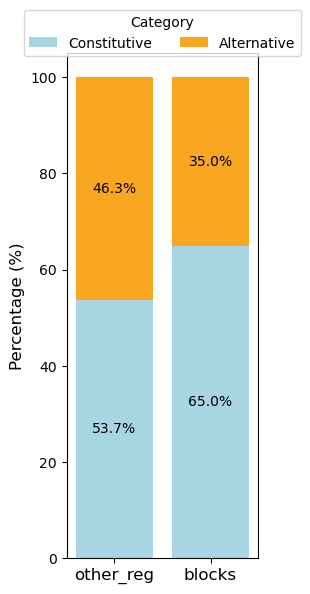

In [18]:
import matplotlib.pyplot as plt

# Define custom colors
custom_colors = ["#A8D5E2", "#F9A620"]

# Data for the plot (replace with the actual calculated percentages)
percentages = {
    "other_reg": other_reg_percentages,
    "blocks": blocks_percentages
    #"whip": whip_percentages,
    # "incl": incl_percentages,
}

# Extract data for plotting
dataframes = list(percentages.keys())
constitutive_values = [percentages[df].get("constitutive", 0) for df in dataframes]
alternative_values = [percentages[df].get("alternative", 0) for df in dataframes]

# Create a stacked bar plot
x = range(len(dataframes))

fig, ax = plt.subplots(figsize=(3, 6))

# Plot constitutive and alternative as stacked bars
bars_constitutive = ax.bar(x, constitutive_values, label="Constitutive", color=custom_colors[0])
bars_alternative = ax.bar(x, alternative_values, bottom=constitutive_values, label="Alternative", color=custom_colors[1])

# Add percentage numbers inside the bars
for i, bar in enumerate(bars_constitutive):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, 
            f"{constitutive_values[i]:.1f}%", ha='center', va='center', fontsize=10, color='black')
for i, bar in enumerate(bars_alternative):
    ax.text(bar.get_x() + bar.get_width() / 2, 
            constitutive_values[i] + bar.get_height() / 2, 
            f"{alternative_values[i]:.1f}%", ha='center', va='center', fontsize=10, color='black')

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(dataframes, fontsize=12)
ax.set_ylabel("Percentage (%)", fontsize=12)
ax.legend(title="Category", fontsize=10, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()

# # Display the plot
plt.savefig('constit_alt_exon_categories.png')
plt.savefig('constit_alt_exon_categories.pdf')
plt.show()
